# Part 4: Advanced Machine Learning Models
<b>Author</b>: Sterling Cutler
<br>
<b>Date</b>: March 24, 2018

## Bagging and Boosting Methods

Bootstrap aggregating, or bagging, can help control model overfitting by reducing noise and variance in the training data. Bagging uses random sampling with replacement on the training data to create multiple learners with their own data subsets and averaging (or voting) the combined model predictions. We'll explore this techinque in more detail with the Random Forest model.

Boosting techniques go a step further by training each learner in stages and adjusting the weights on the underlying data subset based on the learner's accuracy or loss in the previous stage. Then the learners' predictions are combined in a weighted average (or voted) to make a final prediction. We'll explore this technique in more detail with the Gradient Boosting Machine and XGBoost models.

In [1]:
# Load dataset
df <- read.csv("ABI_data.csv")

# Train/test split
train_ind <- sample(nrow(df), size=round(nrow(df)*0.8), replace=FALSE)
x_train <- data.matrix(df[train_ind, 1:6])
x_test <- data.matrix(df[-train_ind, 1:6])
y_train <- df[train_ind, 7]
y_test <- df[-train_ind, 7]

# Print data shapes
cat('Train Data Shape:', dim(x_train), "\n")
cat('Test Data Shape:', dim(x_test))

Train Data Shape: 1071 6 
Test Data Shape: 268 6

## Random Forest

A Random Forest model is an ensemble of decision trees that uses bagging to subset the training data into smaller subsets and takes a random subset of their features (known as "feature bagging"). Randomly sampling the feature variables helps control the impact of a feature highly-correlated with the target variable that would, in turn, cause the trees to become highly correlated with each other. This technique also allows us to measure the importance of the variables in their relationship to the target. As we saw in the last section, our Random Forest model indicates that attorney access and claim age are most important in predicting auto bodily injury losses.

In [2]:
suppressMessages(library(randomForest))

# Fit Random Forest model and view model summary
rf_model <- randomForest(x_train, y_train, x_test, y_test, ntree=500)
print(rf_model)


Call:
 randomForest(x = x_train, y = y_train, xtest = x_test, ytest = y_test,      ntree = 500) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 2

          Mean of squared residuals: 1.506887
                    % Var explained: 29.18
                       Test set MSE: 1.5
                    % Var explained: 34.1


In [3]:
# Tune number of features with cross validation to reduce model error
rf_cv <- rfcv(x_train, y_train, cv.fold=5)
paste(rf_cv$n.var, rf_cv$error.cv)

[1] "6 1.49685097189245" "3 1.50923117697851" "1 1.66873420023139"

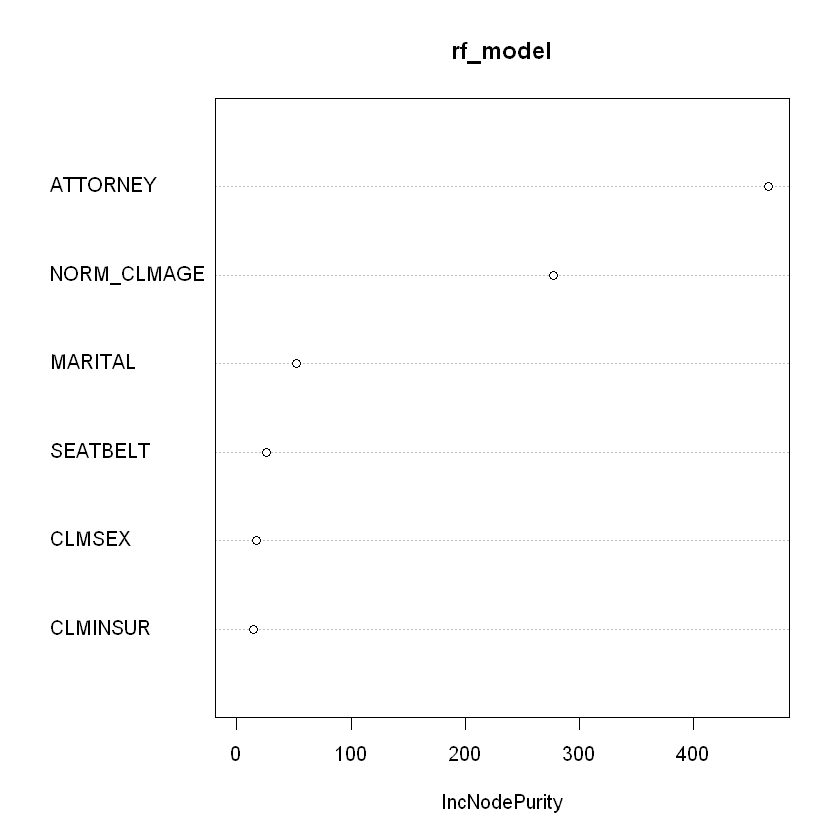

In [4]:
# Plot variable importance
varImpPlot(rf_model, sort=TRUE)

In [5]:
suppressWarnings(library(Metrics))

# Make model predictions against test data
rf_model2 <- randomForest(x_train, y_train, x_test, y_test, ntree=500, mtry=3, keep.forest=TRUE)
rf_preds <- predict(rf_model2, x_test)
paste("RandomForest RMSE:", round(rmse(y_test, rf_preds), 4))

[1] "RandomForest RMSE: 1.2448"

## Gradient Boosting Machine (GBM)

Gradient Boosting Machines uses boosting and the <b>gradient descent</b> optimization method to iteratively build stronger learners and combine their predictions into a final output. Gradient descent uses a learning rate (the <b>shrinkage</b> parameter in the gbm package) to adjust the parameters for each learner to minimize the model's loss function to its globabl minimum value (_i.e._, convergence). Like Random Forest models, GBM models use decision tree models as learners.

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.7841             nan     0.5000    0.3437
     2        1.6585             nan     0.5000    0.1170
     3        1.5646             nan     0.5000    0.0899
     4        1.5301             nan     0.5000    0.0388
     5        1.5125             nan     0.5000    0.0102
     6        1.4936             nan     0.5000    0.0009
     7        1.4702             nan     0.5000    0.0202
     8        1.4711             nan     0.5000   -0.0091
     9        1.4683             nan     0.5000   -0.0040
    10        1.4695             nan     0.5000   -0.0152
    20        1.4503             nan     0.5000   -0.0101
    40        1.4278             nan     0.5000   -0.0168
    60        1.4243             nan     0.5000   -0.0026
    80        1.4237             nan     0.5000   -0.0040
   100        1.4213             nan     0.5000   -0.0150



,var,rel.inf
NORM_CLMAGE,NORM_CLMAGE,55.173467
ATTORNEY,ATTORNEY,34.617352
MARITAL,MARITAL,3.589756
CLMSEX,CLMSEX,2.328185
CLMINSUR,CLMINSUR,2.175036
SEATBELT,SEATBELT,2.116204


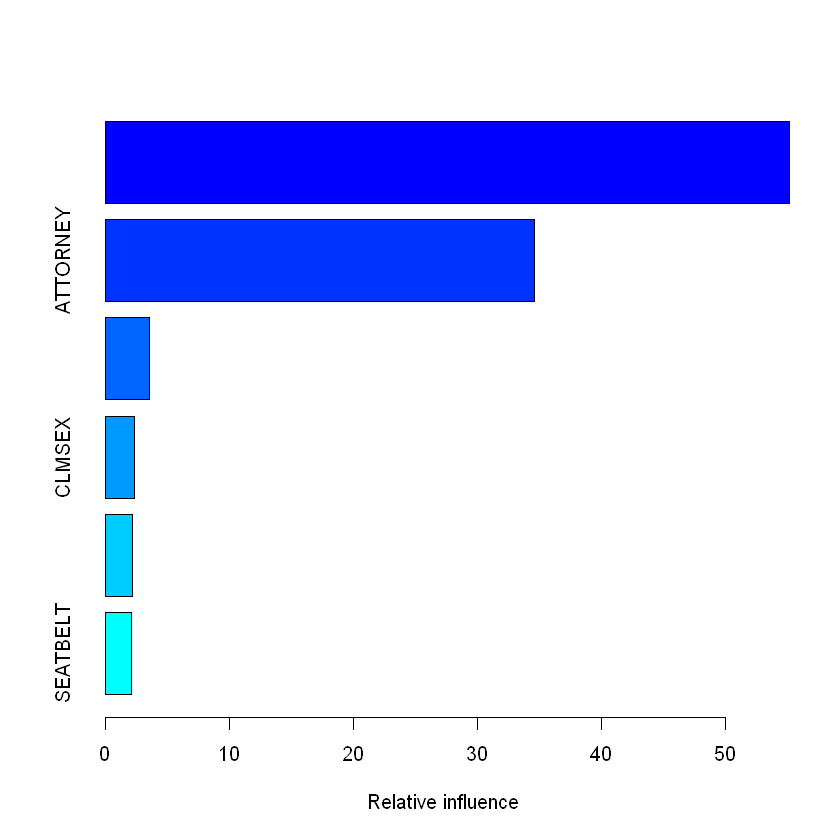

In [6]:
suppressMessages(library(gbm))

# Fit GBM model and print summary
gbm <- gbm.fit(x_train, y_train, distribution="gaussian", n.trees=100,
           shrinkage=0.5, bag.fraction=0.5)
summary(gbm)

Warning message in gbm.perf(gbm, method = "OOB"):
"OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv.folds>0 when calling gbm usually results in improved predictive performance."

[1] "Best iteration: 11"

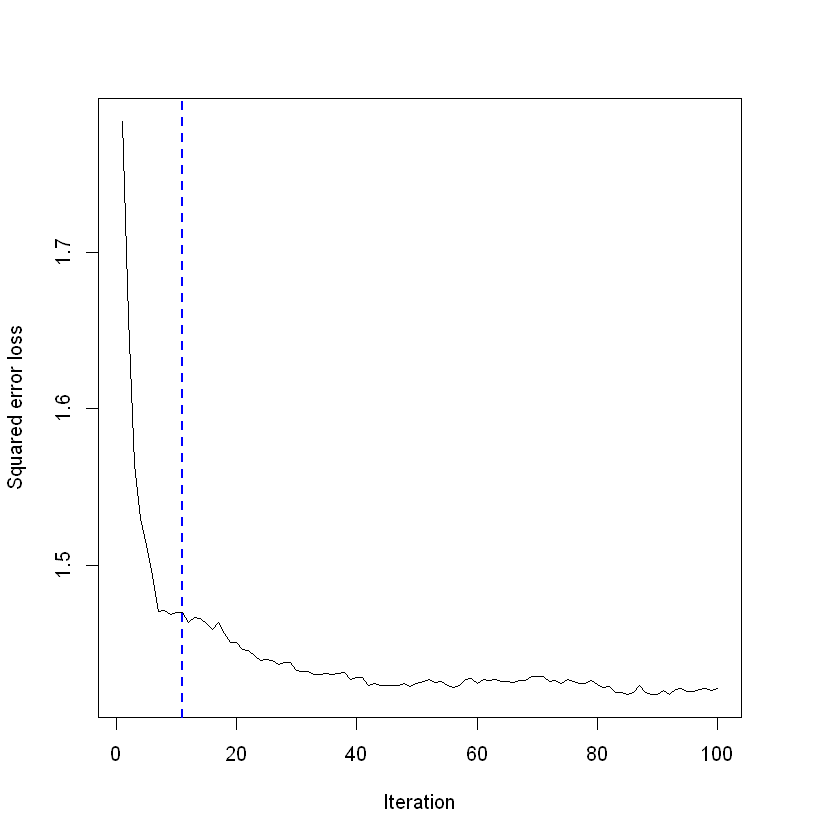

,var,rel.inf
ATTORNEY,ATTORNEY,64.3876707
NORM_CLMAGE,NORM_CLMAGE,31.5203053
SEATBELT,SEATBELT,3.4398616
CLMINSUR,CLMINSUR,0.6521625
CLMSEX,CLMSEX,0.0000000
MARITAL,MARITAL,0.0000000


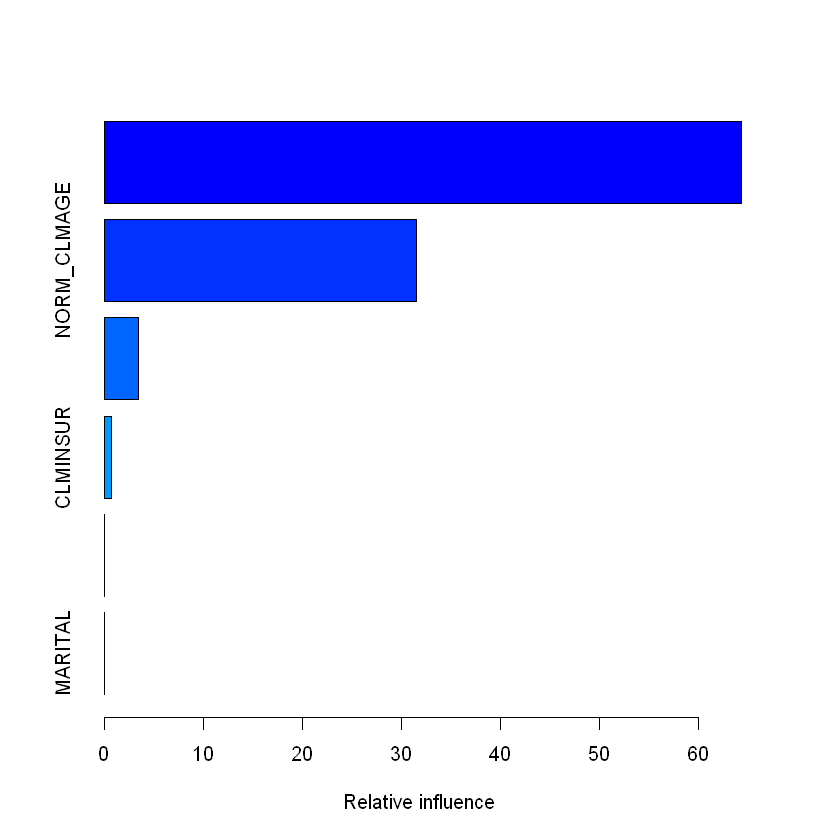

In [7]:
# Use out-of-bag estimator (OOB) to find optimal number of iterations/trees
best_iter <- gbm.perf(gbm, method="OOB")
paste("Best iteration:", best_iter)
summary(gbm, n.trees=best_iter)

In [8]:
# Predict target for test data
gbm_preds <- predict(gbm, x_test, best_iter)
paste("GBM RMSE:", round(rmse(y_test, gbm_preds), 4))

[1] "GBM RMSE: 1.2223"

## XGBOOST

Extreme Gradient Boosting, or XGBoost, adds a regularization term to the objective function control model complexity and leverages the available computational and memory resources for faster performance. The regularization helps avoid model overfitting and stronger hardware optimization enables us to test lower learning rates (the <b>eta</b> parameter in XGBoost) within a reasonable timeframe. XGBoost also allows L1 and L2 regularization in training. With some parameter tuning, we can use this model to outperform the others and achieve the lowest root mean squared error.

In [9]:
library(xgboost)

# Fit model to training data
dtrain <- xgb.DMatrix(x_train, label=y_train)
cntrl = list(eta=0.01, max_depth=3, gamma=0.3)
xgb <- xgb.train(params=cntrl, data=dtrain, nrounds=500)

In [10]:
# Use cross validation for model tuning and testing
cv <- xgb.cv(data=dtrain, nrounds=10, nfold=5, metrics="rmse", objective="reg:linear")
print(cv)

[1]	train-rmse:1.347913+0.008022	test-rmse:1.380803+0.033485 
[2]	train-rmse:1.259968+0.006047	test-rmse:1.322579+0.027855 
[3]	train-rmse:1.205920+0.007300	test-rmse:1.294853+0.029368 
[4]	train-rmse:1.170567+0.006580	test-rmse:1.282010+0.029056 
[5]	train-rmse:1.147813+0.008437	test-rmse:1.281277+0.026704 
[6]	train-rmse:1.131539+0.008752	test-rmse:1.284291+0.026284 
[7]	train-rmse:1.117117+0.010963	test-rmse:1.287854+0.027408 
[8]	train-rmse:1.105062+0.012578	test-rmse:1.294920+0.029172 
[9]	train-rmse:1.096223+0.011898	test-rmse:1.296898+0.030535 
[10]	train-rmse:1.088055+0.009963	test-rmse:1.300770+0.033431 
##### xgb.cv 5-folds
 iter train_rmse_mean train_rmse_std test_rmse_mean test_rmse_std
    1        1.347913    0.008022137       1.380803    0.03348468
    2        1.259968    0.006046821       1.322579    0.02785495
    3        1.205920    0.007300221       1.294853    0.02936761
    4        1.170567    0.006579842       1.282010    0.02905632
    5        1.147813    0.0

       Feature        Gain       Cover  Frequency
1:    ATTORNEY 0.618168632 0.215374605 0.10366032
2: NORM_CLMAGE 0.322502180 0.580265116 0.60497804
3:     MARITAL 0.036615406 0.077137022 0.14582723
4:    SEATBELT 0.016286166 0.115747561 0.07525622
5:      CLMSEX 0.004340028 0.008988911 0.05212299
6:    CLMINSUR 0.002087589 0.002486785 0.01815520


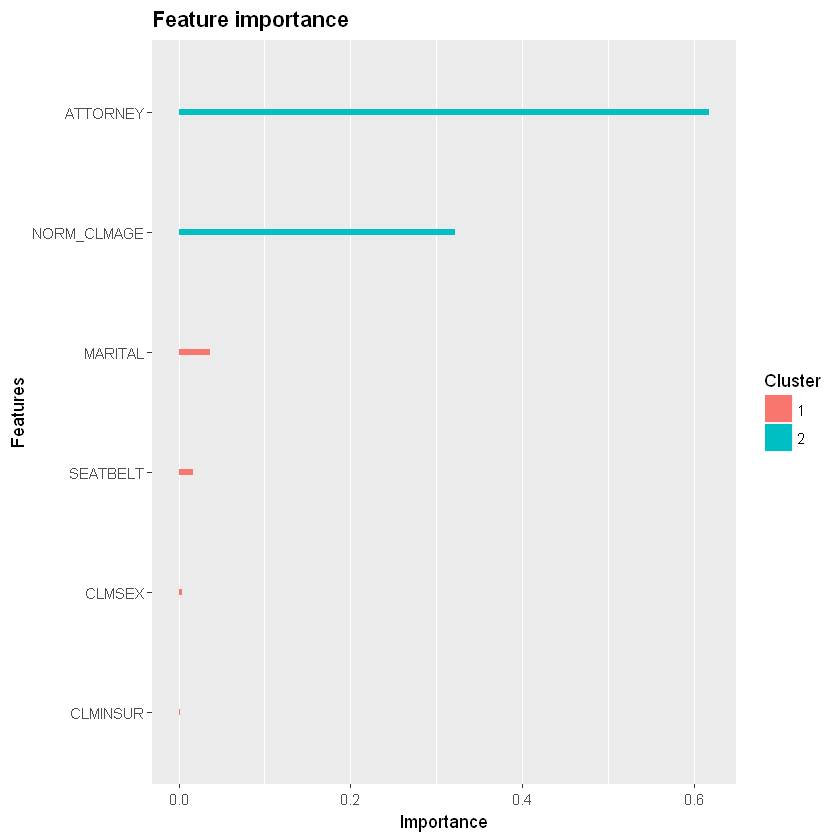

In [11]:
suppressMessages(library(ggplot2))

# Show and plot feature importance
importances <- xgb.importance(colnames(x_train), xgb)
print(importances)
xgb.ggplot.importance(importances)

In [12]:
# Fit better model based on parameter experimentation
cntrl = list(eta=0.01, max_depth=2, alpha=1.0, gamma=1.0)
xgb <- xgb.train(params=cntrl, data=dtrain, nrounds=1000)

In [13]:
# Make model predictions against test data
xgb_preds <- predict(xgb, x_test)
paste("XGBoost RMSE:", round(rmse(y_test, xgb_preds), 4))

[1] "XGBoost RMSE: 1.0981"

## Going Further: Other Models and Techniques

There are many other models available for performing regression analysis (e.g., neural networks), as well as classification, clustering, natural language processing, association analysis, and other applications. These models and techniques can play a strong role in improving various insurance applications such as underwriting, market segmentation, and risk engineering.

Another useful ensemble techinque, known as stacking, combines the predictions from several models and uses them as input attribute data into another model. The prediction ensemble can be used independently from or concatenated to the original training data, depending on which final model you're using and its control on multicollinearity. Feature selection methods and dimensionality reduction techniques (_e.g._, Principal Component Analysis) can also help.

Sometimes complex models and/or large datasets cannot run on a single core or machine in a stable and timely manner. Great packages like XGBoost and H2O allow users to leverage parallel processing and Hadoop-based frameworks to divide this labor across several cores or machines.